In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
import pandas as pd
import glob
import os

pfad = "../data/tageswerte_pro_Jahr/*.csv"   # z.B. "data/*.csv" oder "C:/Users/du/fahrrad/*.csv"

dateien = glob.glob(pfad)
dfs = []
for datei in dateien:
    df_temp = pd.read_csv(datei)
    jahr = os.path.basename(datei).split("_")[2].split(".")[0]
    df_temp["year"] = jahr
    dfs.append(df_temp.astype({"year":int}))

df = pd.concat(dfs, ignore_index=True)



/tmp/ipykernel_481669/4284432569.py:10: DtypeWarning: Columns (10,11,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(datei)
/tmp/ipykernel_481669/4284432569.py:10: DtypeWarning: Columns (10,11,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(datei)


In [18]:
# Daten bereinigen

# replace various forms of 'na' with np.nan
df = df.replace(["na", "NA", "Na"], np.nan)
print(df.isna().sum())
# TODO Find if temp rain and snow values are missing in a pattern or at random
# convert numeric values to corresponding dtypes
df["site_temperature"] = df["site_temperature"].astype(float)
df["site_rain_accumulation"] = df["site_rain_accumulation"].astype(float)
df["site_snow_accumulation"] = df["site_snow_accumulation"].astype(float)

# Mannheim subset, saved to file
df_ma = df[df["domain_name"] == 'Stadt Mannheim']
df_ma.to_csv("../data/processed/bikes_mannheim.csv", index=False)
print(df_ma.isna().sum())


operator_name                  0
domain_name                    0
domain_id                      0
counter_site                   0
counter_site_id                0
counter_serial              1593
longitude                      0
latitude                       0
timezone                       0
iso_timestamp                  0
channels_in                26510
channels_out               26559
channels_unknown          220492
channels_all                   0
site_temperature           20642
site_rain_accumulation     20642
site_snow_accumulation     20656
year                           0
dtype: int64
operator_name                 0
domain_name                   0
domain_id                     0
counter_site                  0
counter_site_id               0
counter_serial                0
longitude                     0
latitude                      0
timezone                      0
iso_timestamp                 0
channels_in                   0
channels_out                  0
channels_

In [19]:
# Shorten der Labels für bessere Lesbarkeit im Plot
max_length = 15
df_ma["short_labels"] = df_ma["counter_site"].apply(lambda x: x[:max_length] + ("…" if len(x) > max_length else ""))

/tmp/ipykernel_481669/3477491348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ma["short_labels"] = df_ma["counter_site"].apply(lambda x: x[:max_length] + ("…" if len(x) > max_length else ""))


/tmp/ipykernel_481669/3785016934.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(range(0,3501, 500))


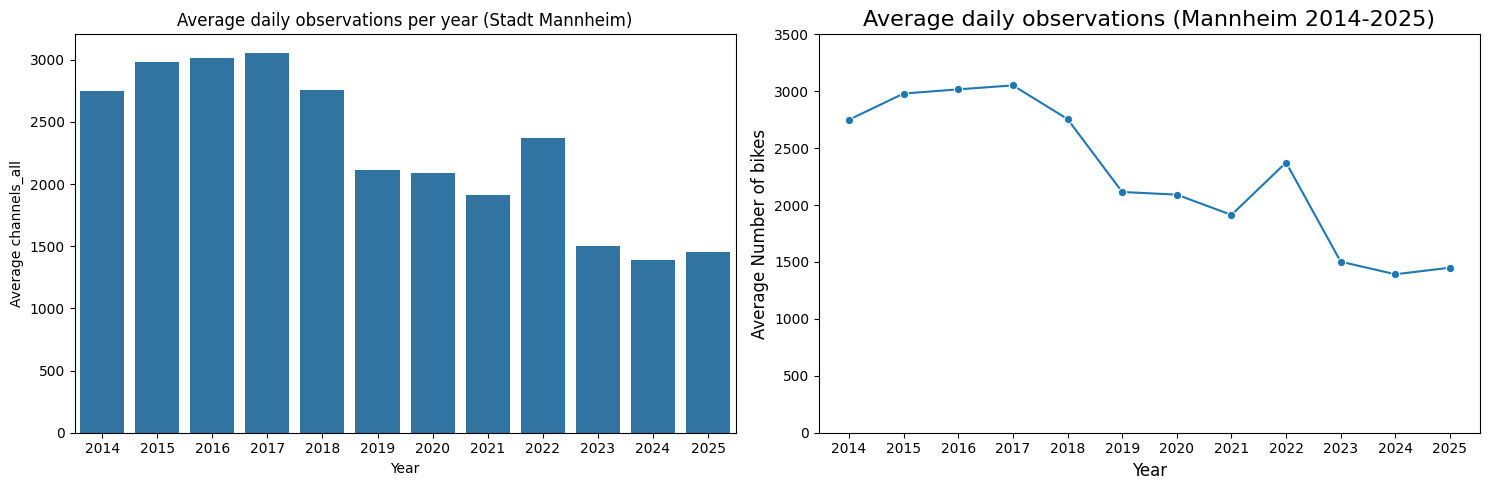

In [67]:
avg_per_year = df_ma.groupby("year")["channels_all"].mean()
years = avg_per_year.index.astype(str)
fig, axs = plt.subplots(1,2, figsize=(15, 5))

sns.barplot(x=years, y=avg_per_year.values, ax=axs[0])
axs[1].set_yticks(range(0, 3501, 500))
axs[0].set_yticklabels(range(0,3501, 500))
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average channels_all")
axs[0].set_title("Average daily observations per year (Stadt Mannheim)")


# WICHTIG Hier kommt der Abfall des Mittelwerts dadurch, dass mehr Zählstationen hinzugefügt wurden, die nicht an einem Hotspot standen, also Mittelwert sinkt.
plot_data = pd.DataFrame({
    'Year': years,
    'Average': avg_per_year
})

sns.lineplot(x='Year', y='Average', data=plot_data, marker='o', ax=axs[1])
axs[1].set_yticks(range(0, 3501, 500))
axs[1].set_yticklabels(range(0,3501, 500))
axs[1].set_title("Average daily observations (Mannheim 2014-2025)", fontsize=16)
axs[1].set_xlabel("Year", fontsize=12)
axs[1].set_ylabel("Average Number of bikes", fontsize=12)

plt.tight_layout()
plt.show()

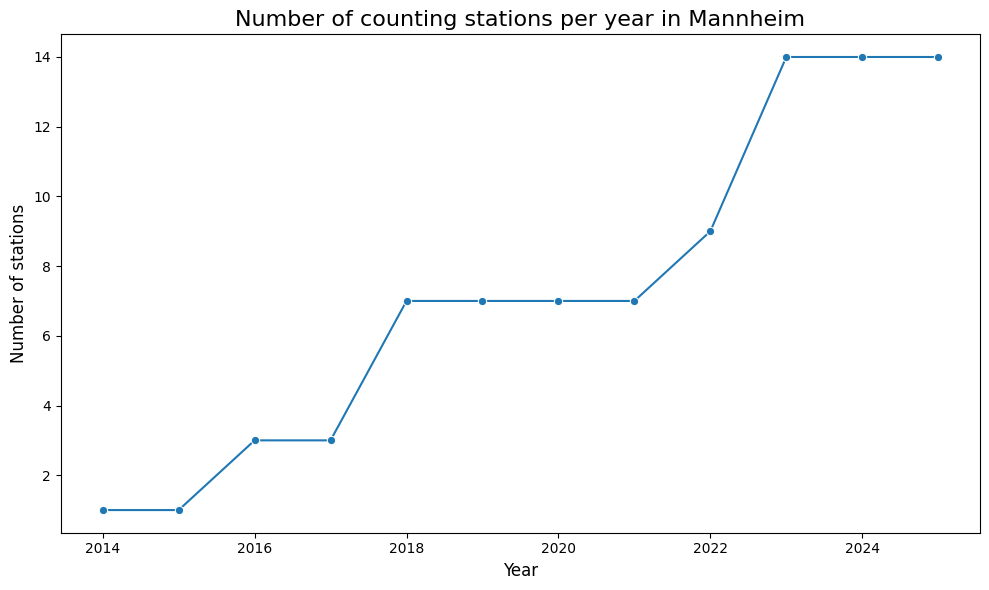

In [68]:
y = df_ma.groupby(by="year")["counter_site"].nunique()
plt.figure(figsize=(10, 6))
sns.lineplot(x=y.index, y=y.values, marker='o')
plt.title("Number of counting stations per year in Mannheim", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of stations", fontsize=12)
plt.tight_layout()
plt.show()


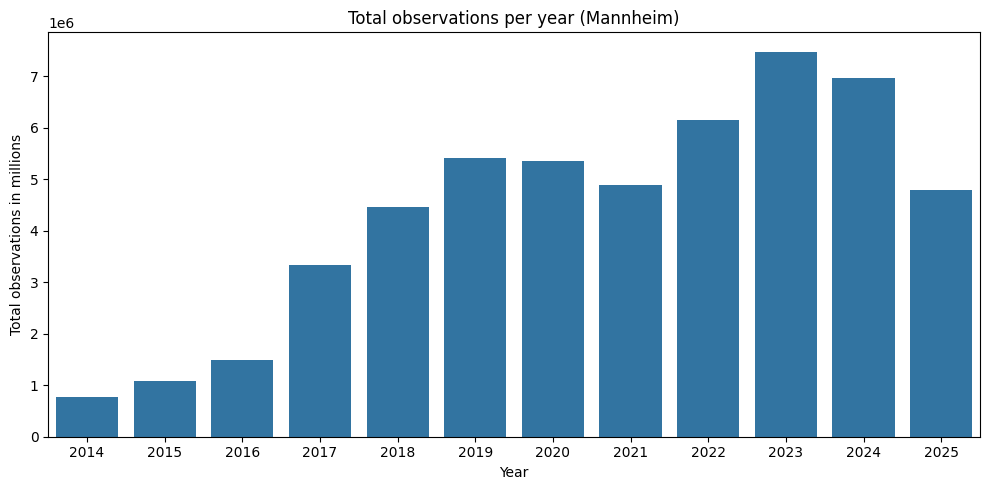

In [74]:
sum_per_year = df_ma.groupby("year")["channels_all"].sum()

sum_per_year = sum_per_year.sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=years, y=sum_per_year.values)

plt.xlabel("Year")
plt.ylabel("Total observations in millions")
plt.title("Total observations per year (Mannheim)")
plt.tight_layout()
plt.show()

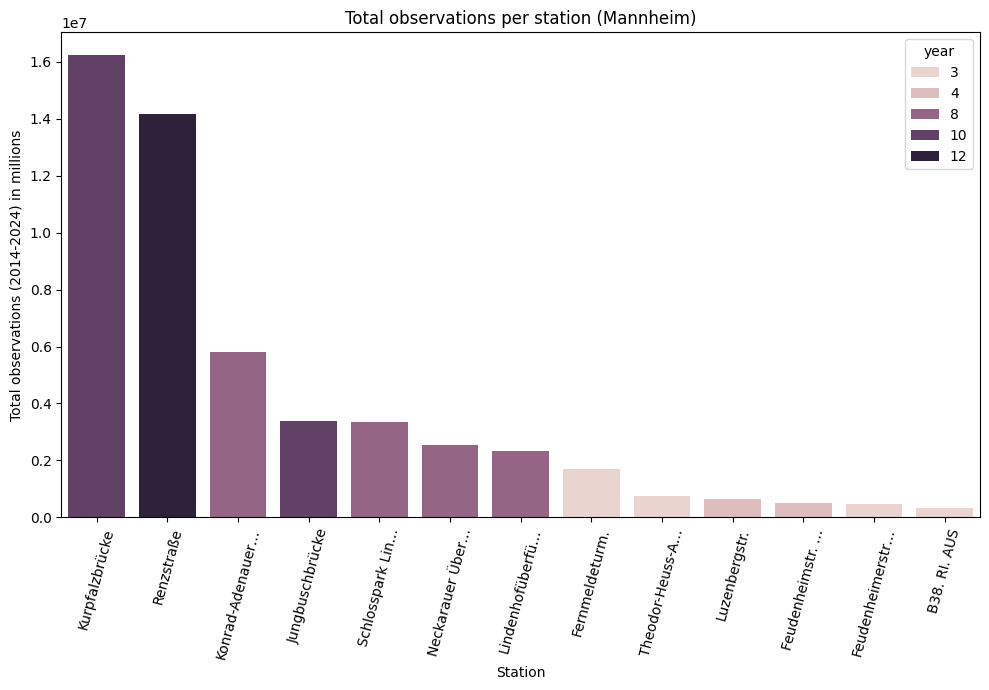

In [90]:
station_sum = df_ma.groupby("short_labels")["channels_all"].sum().sort_values(ascending=False)
year_counts = df_ma.groupby("short_labels")["year"].nunique()
year_counts = year_counts[station_sum.index]  # Reorder year_counts to match the sorted station_sum

plt.figure(figsize=(10, 7))
sns.barplot(x=station_sum.index, y=station_sum.values, hue=year_counts)
plt.xticks(rotation=75)
plt.xlabel("Station")
plt.ylabel("Total observations (2014-2024) in millions")
plt.title("Total observations per station (Mannheim)")
plt.tight_layout()
plt.show()

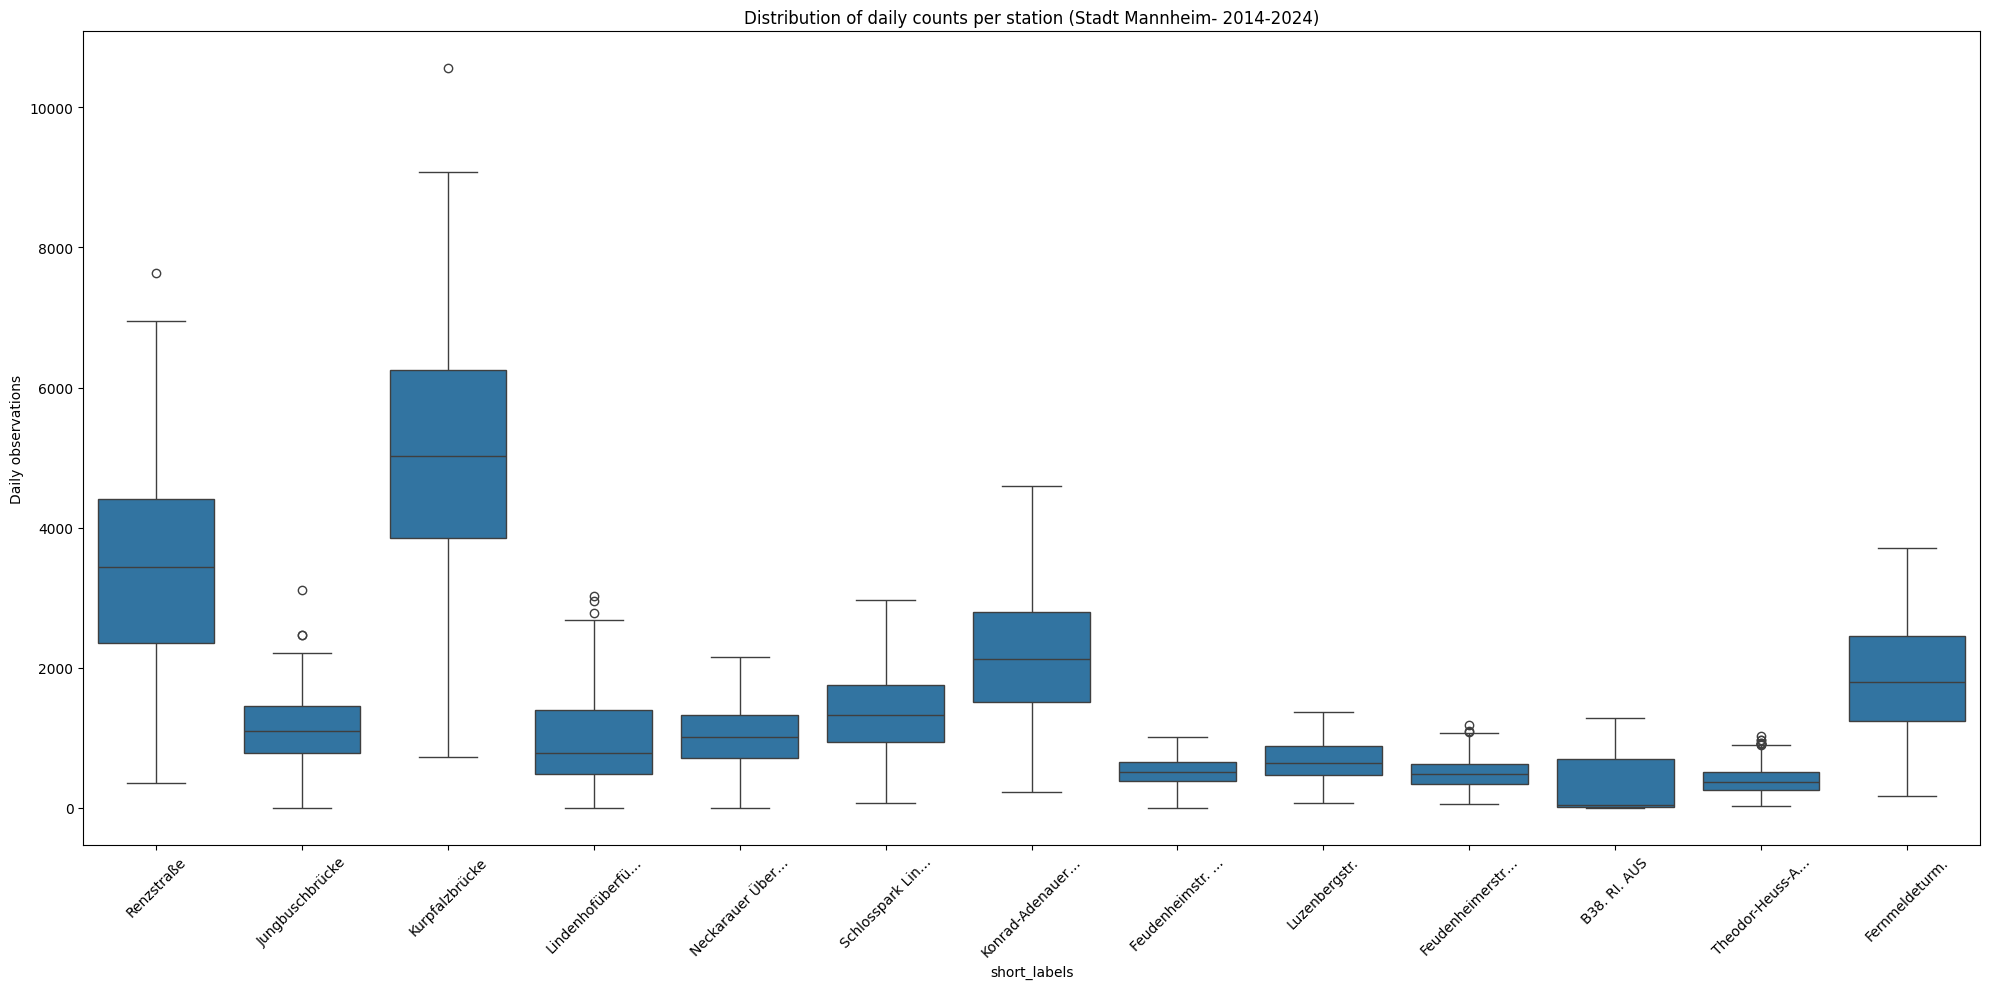

In [ ]:
import matplotlib.pyplot as plt

max_length = 15

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_ma, x="short_labels", y="channels_all")
plt.xticks(rotation=45)
plt.ylabel("Daily observations")
plt.title("Distribution of daily counts per station (Stadt Mannheim- 2014-2024)")
plt.tight_layout()
plt.show()
# TODO Was sind die sehr großen Outlier? An welchem Tag waren sie und was war da? Alle am gleichen Tag? Renzstraße und Kurpfalzbrücke

# Korrelation zwischen Temperatur und Fahrradnutzung

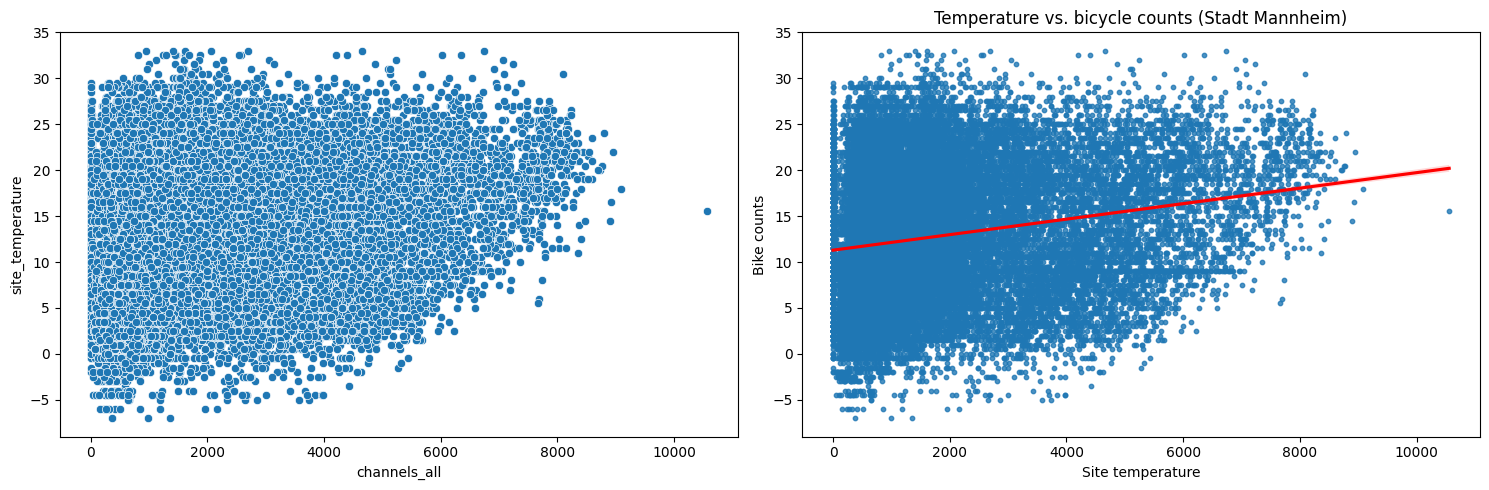

Pearson: 0.202
Spearman: 0.223
Pearson: 0.195
Spearman: 0.272


In [26]:
fig, axs = plt.subplots(1,2,figsize=(15, 5))
sns.scatterplot(data=df_ma, y="site_temperature", x="channels_all", ax=axs[0])
sns.regplot(data=df_ma, y="site_temperature", x="channels_all",scatter_kws={'s': 10}, line_kws={'color': 'red'}, ax=axs[1])
plt.xlabel("Site temperature")
plt.ylabel("Bike counts") 
plt.title("Temperature vs. bicycle counts (Stadt Mannheim)")
plt.tight_layout()
plt.show()
# Pearson
pearson_ma = df_ma[["channels_all", "site_temperature"]].corr(method="pearson").loc["channels_all", "site_temperature"]

# Spearman
spearman_ma = df_ma[["channels_all", "site_temperature"]].corr(method="spearman").loc["channels_all", "site_temperature"]

print(f"Pearson: {pearson_ma:.3f}")
print(f"Spearman: {spearman_ma:.3f}")

# Drop all nan values in site_temperature from big dataframe
df["site_temperature"] = df["site_temperature"].replace(["na", "NA", "Na"], np.nan)
df = df.dropna(subset=["site_temperature"])
pearson_all = df[["channels_all", "site_temperature"]].corr(method="pearson").loc["channels_all", "site_temperature"]
spearman_all = df[["channels_all", "site_temperature"]].corr(method="spearman").loc["channels_all", "site_temperature"]

print(f"Pearson: {pearson_all:.3f}")
print(f"Spearman: {spearman_all:.3f}")

#### Die insgesamte Korrelation zwischen der Temperatur und der Fahrradnutzung in Mannheim beträgt nach Pearson 0.202.
#### Betrachtet man jedoch die Korrelation der einzelnen der Messstationen so ergeben sich folgende Werte.

        short_labels  pearson_corr
1       B38. RI. AUS      0.011942
15  Lindenhofüberfü…      0.235979
25  Theodor-Heuss-A…      0.381730
21        Renzstraße      0.445103
19  Neckarauer Über…      0.486533
5   Feudenheimerstr…      0.510540
7   Feudenheimstr. …      0.533080
13    Kurpfalzbrücke      0.548310
9    Jungbuschbrücke      0.557844
11  Konrad-Adenauer…      0.568114
17     Luzenbergstr.      0.584917
3     Fernmeldeturm.      0.619432
23  Schlosspark Lin…      0.629848


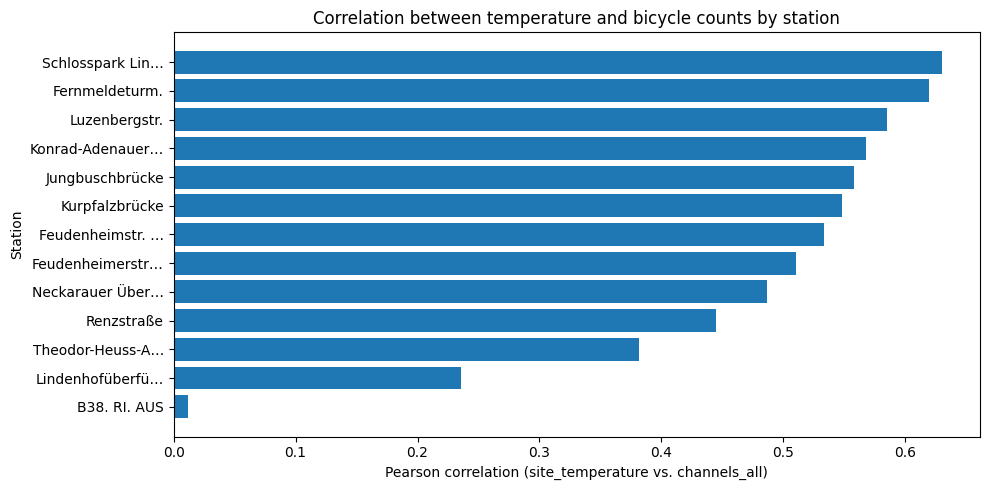

In [27]:
corr_per_station = (
    df_ma.groupby("short_labels")[["channels_all", "site_temperature"]]
         .corr(method="pearson")
         .reset_index()
)

# Nur die Zeilen channels_all vs. site_temperature extrahieren
corr_per_station = corr_per_station[
    (corr_per_station["level_1"] == "site_temperature") &
    (corr_per_station["short_labels"].notna())
][["short_labels", "channels_all"]].rename(columns={"channels_all": "pearson_corr"})

print(corr_per_station.sort_values("pearson_corr"))

corr_per_station_sorted = corr_per_station.sort_values("pearson_corr")

plt.figure(figsize=(10, 5))
plt.barh(corr_per_station_sorted["short_labels"], corr_per_station_sorted["pearson_corr"])
plt.xlabel("Pearson correlation (site_temperature vs. channels_all)")
plt.ylabel("Station")
plt.title("Correlation between temperature and bicycle counts by station")
plt.tight_layout()
plt.show()

An den meisten Stationen ist die Korrelation positiv (d.h. wärmere Tage → mehr Radverkehr).“
„Die Stärke variiert jedoch deutlich zwischen den Stationen (von ~0 bis ~0.63).“
„Insbesondere an Stationen X, Y, Z ist der Zusammenhang besonders stark.“